-----------------------------------------


Copyright 2016 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

import thinkbayes2
import thinkplot

import numpy as np
from scipy import stats

%matplotlib inline

Here's an update that takes the prior probability of being sick `prior`=$x$, and the likelihoods of the data, `prob_given_sick`=$P(fever|sick)$ and `prob_given_not` =$P(fever|not sick)$

In [2]:
def update(prior, prob_given_sick, prob_given_not):
    suite = thinkbayes2.Suite()
    suite['sick'] = prior * prob_given_sick
    suite['not sick'] = (1-prior) * prob_given_not
    suite.Normalize()
    return suite['sick']

If we start with $x=0.1$ and update with the assumption that fever is more likely if you're sick, the posterior goes up to $x\prime = 0.25$

In [3]:
prior = 0.1
prob_given_sick = 0.9
prob_given_not = 0.3

post = update(prior, prob_given_sick, prob_given_not)
post

0.24999999999999997

Now suppose we don't know $s =$ `prob_given_sick`=$P(fever|sick)$ and $t = $ `prob_given_not` =$P(fever|not sick)$, but we think they are uniformly distributed and independent.

In [4]:
dist_s = thinkbayes2.Beta(1, 1)
dist_t = thinkbayes2.Beta(1, 1)
dist_s.Mean(), dist_t.Mean()

(0.5, 0.5)

We can compute the distribute of $x\prime$ by drawing samples from the distributions of $s$ and $t$ and computing the posterior for each.

In [5]:
n = 1000
ss = dist_s.Sample(n)
ts = dist_t.Sample(n)

Just checking that the samples have the right distributions:

{'xscale': 'linear', 'yscale': 'linear'}

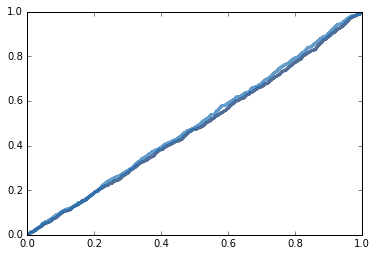

In [6]:
thinkplot.Cdf(thinkbayes2.Cdf(ss))
thinkplot.Cdf(thinkbayes2.Cdf(ts))

Now computing the posteriors:

In [7]:
posts = [update(prior, s, t) for s, t in zip(ss, ts)]

Here's what the distribution of values for $x\prime$ looks like:

{'xscale': 'linear', 'yscale': 'linear'}

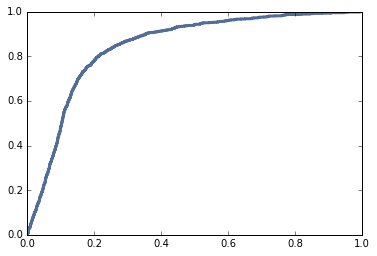

In [8]:
cdf = thinkbayes2.Cdf(posts)
thinkplot.Cdf(cdf)

And here's the mean:

In [9]:
cdf.Mean()

0.15586200108737797

This result implies that if our prior probability for $x$ is 0.1, and then we learn that the patient has a fever, we should be uncertain about $x\prime$, and this distribution describes that uncertainty.  It says that the fever probably has little predictive power, but might have quite a lot.

The mean of this distribution is a little higher than the prior, which suggests that our priors for $s$ and $t$ are not neutral with respect to updating $x$.  It's surprising that the effect is not symmetric, because our beliefs about $s$ and $t$ are symmetric.  But then again, we just computed an arithmetic mean on a set of probabilities, which is a bogus kind of thing to do.  So maybe we deserve what we got.

Just for fun, what would we have to believe about $s$ and $t$ to make them neutral with respect to the posterior mean of $x$?

{'xscale': 'linear', 'yscale': 'linear'}

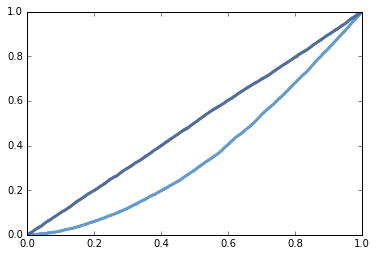

In [10]:
dist_s = thinkbayes2.Beta(1, 1)
dist_t = thinkbayes2.Beta(1.75, 1)
n = 10000
ss = dist_s.Sample(n)
ts = dist_t.Sample(n)
thinkplot.Cdf(thinkbayes2.Cdf(ss))
thinkplot.Cdf(thinkbayes2.Cdf(ts))

In [11]:
posts = [update(prior, s, t) for s, t in zip(ss, ts)]
np.array(posts).mean()

0.097733895049857883

Now here's a version that simulates worlds where $x$ is known and $s$ and $t$ are drawn from uniform distributions.  For each $s$-$t$ pair, we generate one patient with a fever and compute the probability that they are sick.

In [12]:
def prob_sick(x, s, t):
    return x * s / (x * s + (1-x) * t)

In [13]:
dist_s = thinkbayes2.Beta(1, 1)
dist_t = thinkbayes2.Beta(1, 1)
n = 10000
ss = dist_s.Sample(n)
ts = dist_t.Sample(n)

In [14]:
x = 0.1
probs = [prob_sick(x, s, t) for s, t in zip(ss, ts)]

In [15]:
np.array(probs).mean()

0.15306534465160232

In [16]:
cohort = np.random.random(len(probs)) < probs

In [17]:
cohort.mean()

0.1439

April 6, 2016

Suppose 
* t is known to be 0.5
* x is known to be 0.1
* s is equally likely to be 0.2 or 0.8, but we don't know which

If we take the average value of s and compute p = p(sick|fever), we would consider p to be the known quantity 0.1 

In [26]:
s = 0.5
t = 0.5
x = 0.1
p = x * s / (x * s + (1-x) * t)
p

0.1

If we propagate the uncertainty about s through the calculation, we consider p to be either p1 or p2, but we don't know which.

In [36]:
t = 0.8
p1 = x * s / (x * s + (1-x) * t)
p1, 5/77

(0.06493506493506493, 0.06493506493506493)

In [35]:
t = 0.2
p2 = x * s / (x * s + (1-x) * t)
p2, 5/23

(0.21739130434782605, 0.21739130434782608)

If we were asked to make a prediction about a single patient, we would average the two possible values of p.

In [29]:
(p1 + p2) / 2

0.1411631846414455

In [34]:
def logodds(p):
    return np.log(p / (1-p))

logodds(p1) - logodds(0.1), logodds(p2) - logodds(0.1)

(-0.47000362924573613, 0.91629073187415466)

In [37]:
p_mix = (p1 + p2) / 2
logodds(p_mix) - logodds(0.1)

0.39156220293917254

So let's simulate a series of patients by drawing a random value of y, computing p, and then tossing coins with probability p.

In [30]:
import random

def simulate_patient():
    s = 0.5
    t = random.choice([0.2, 0.8])
    x = 0.1
    p = x * s / (x * s + (1-x) * t)
    return random.random() < p

simulate_patient()

False

In this simulation, the fraction of patients with fever who turn out to be sick is close to 0.141

In [31]:
patients = [simulate_patient() for _ in range(10000)]
sum(patients) / len(patients)

0.1402

In [153]:
x = 0.1
s = 0.5
t1 = 0.2
t2 = 0.8

In [154]:
import pandas as pd
d1 = dict(feverbad=0.5, fevergood=0.5)
d2 = dict(sick=x, notsick=1-x)
d3 = dict(fever='t', notfever='1-t')

iterables = [d1.keys(), d2.keys(), d3.keys()]

index = pd.MultiIndex.from_product(iterables, names=['first', 'second', 'third'])
df = pd.DataFrame(np.zeros(8), index=index, columns=['prob'])

In [155]:
t_map = dict(fevergood=t2, feverbad=t1)

for label1, p1 in d1.items():
    t = t_map[label1]
    for label2, p2 in d2.items():
        for label3, p3 in d3.items():
            if label2 == 'sick':
                p = p1 * p2 * 0.5
            else:
                p = p1 * p2 * eval(p3)

            df.prob[label1, label2, label3] = p
            
df    

prob
first     second  third          
fevergood notsick fever     0.360
                  notfever  0.090
          sick    fever     0.025
                  notfever  0.025
feverbad  notsick fever     0.090
                  notfever  0.360
          sick    fever     0.025
                  notfever  0.025

If there are two kinds of people, some more fever prone than others, and we don't know which kind of patient we're dealing with, P(sick | fever)

In [157]:
df.prob[:, 'sick', 'fever'].sum() / df.prob[:, :, 'fever'].sum()

0.09999999999999998

If we know fevergood, P(sick|fever) is

In [158]:
p_sick_fevergood = df.prob['fevergood', 'sick', 'fever'].sum() / df.prob['fevergood', :, 'fever'].sum()
p_sick_fevergood

0.064935064935064929

If we know feverbad, P(sick|fever) is

In [149]:
p_sick_feverbad = df.prob['feverbad', 'sick', 'fever'].sum() / df.prob['feverbad', :, 'fever'].sum()
p_sick_feverbad

0.21739130434782605

If we think there's a 50-50 chance of feverbad

In [159]:
(p_sick_fevergood + p_sick_feverbad) / 2

0.1411631846414455

If fevergood, here's the fraction of all patients with fever:

In [143]:
p_fever_fevergood = df.prob['fevergood', :, 'fever'].sum()
p_fever_fevergood

0.38500000000000006

If fever bad, here's the fraction of all patients with fever

In [144]:
p_fever_feverbad = df.prob['feverbad', :, 'fever'].sum()
p_fever_feverbad

0.11500000000000002

So if we started out thinking there's a 50-50 chance of feverbad, we should now think feverbad is less likely

In [146]:
p_feverbad_fever = p_fever_feverbad / (p_fever_feverbad + p_fever_fevergood)
p_feverbad_fever

0.22999999999999998

And if we compute the weighted sum of the two possible worlds

In [150]:
p_feverbad_fever * p_sick_feverbad + (1-p_feverbad_fever) * p_sick_fevergood

0.099999999999999978